In [1]:
import sklearn as sk
import numpy as np
import torch
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
matplotlib.rc("font",family='YouYuan')

In [2]:
ML_ready=pd.read_csv(".\\ML_ready.csv")
ML_ready['planet_to_star_radius'] = ML_ready['planet_radius'] / ML_ready['star_radius']
ML_ready['star_density'] = ML_ready['star_mass'] / (ML_ready['star_radius'] ** 3)
ML_ready['j_minus_k'] = ML_ready['j_mag'] - ML_ready['k_mag']
ML_ready['h_minus_k'] = ML_ready['h_mag'] - ML_ready['k_mag']
#ML_ready['log_planet_radius'] = np.log1p(ML_ready['planet_radius'])
#ML_ready['log_orbital_period'] = np.log1p(ML_ready['orbital_period'])
#ML_ready['log_star_mass'] = np.log1p(ML_ready['star_mass'])
ML_ready['radius_times_period'] = ML_ready['planet_radius'] * ML_ready['orbital_period']
ML_ready['radius_over_mass'] = ML_ready['planet_radius'] / ML_ready['star_mass']

In [3]:
ML_ready.info()
ML_ready.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19761 entries, 0 to 19760
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PC1                    19761 non-null  float64
 1   PC2                    19761 non-null  float64
 2   PC3                    19761 non-null  float64
 3   label                  19761 non-null  int64  
 4   ra                     19761 non-null  float64
 5   dec                    19761 non-null  float64
 6   j_mag                  19761 non-null  float64
 7   h_mag                  19761 non-null  float64
 8   k_mag                  19761 non-null  float64
 9   kep_mag                19761 non-null  float64
 10  planet_radius          19761 non-null  float64
 11  orbital_period         19761 non-null  float64
 12  star_teff              19761 non-null  float64
 13  star_logg              19761 non-null  float64
 14  star_radius            19761 non-null  float64
 15  st

,PC1,PC2,PC3,label,ra,dec,j_mag,h_mag,k_mag,kep_mag,...,star_logg,star_radius,star_mass,lc_time0,planet_to_star_radius,star_density,j_minus_k,h_minus_k,radius_times_period,radius_over_mass
0,-0.329993,-0.469118,-0.051703,2,297.00482,48.134129,14.254,13.900,13.826,15.436,...,4.544,0.868,0.961,175.850252,16.820276,1.469482,0.428,0.074,290.527443,15.192508
1,0.093289,-0.453369,0.408759,2,285.53461,48.285210,14.326,13.911,13.809,15.597,...,4.564,0.791,0.836,170.307565,42.300885,1.689183,0.517,0.102,58.118429,40.023923
2,-0.469821,-0.455314,0.015327,0,288.75488,48.226200,14.366,14.064,13.952,15.509,...,4.438,1.046,1.095,171.595550,2.629063,0.956795,0.414,0.112,6.945377,2.511416
3,-0.296522,0.062012,0.022569,0,296.28613,48.224670,14.528,14.113,14.132,15.714,...,4.486,0.972,1.053,171.201160,4.012346,1.146647,0.396,-0.019,43.267850,3.703704
4,-0.399275,-0.189558,0.008973,0,296.28613,48.224670,14.528,14.113,14.132,15.714,...,4.486,0.972,1.053,172.979370,2.849794,1.146647,0.396,-0.019,11.452385,2.630579


目标变量分布：
label
1    7413
0    6311
2    6015
3      22
Name: count, dtype: int64


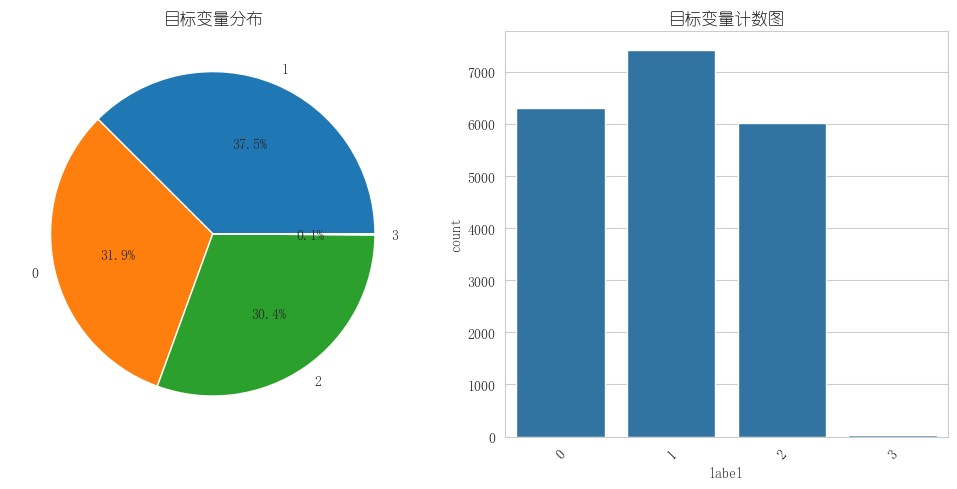

In [4]:
print("目标变量分布：")
label_counts = ML_ready['label'].value_counts()
print(label_counts)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
plt.title('目标变量分布')

plt.subplot(1, 3, 2)
sns.countplot(data=ML_ready, x='label')
plt.title('目标变量计数图')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

数值特征的描述性统计：
                PC1           PC2           PC3         label            ra  \
count  19761.000000  19761.000000  19761.000000  19761.000000  19761.000000   
mean      -0.133381     -0.086460     -0.030991      0.987248    225.530937   
std        1.024262      0.799844      0.503856      0.792513     95.189927   
min       -0.591683     -2.864373     -7.777481      0.000000      0.084680   
25%       -0.442493     -0.411154     -0.044433      0.000000    136.755357   
50%       -0.383010     -0.209012     -0.009771      1.000000    285.099760   
75%       -0.273000     -0.003262      0.001964      2.000000    294.618930   
max       13.803377     24.012589      7.424680      3.000000    359.941195   

                dec         j_mag         h_mag         k_mag       kep_mag  \
count  19761.000000  19761.000000  19761.000000  19761.000000  19761.000000   
mean      18.569540     12.532646     12.139621     12.050162     12.936044   
std       36.993569      1.232746      

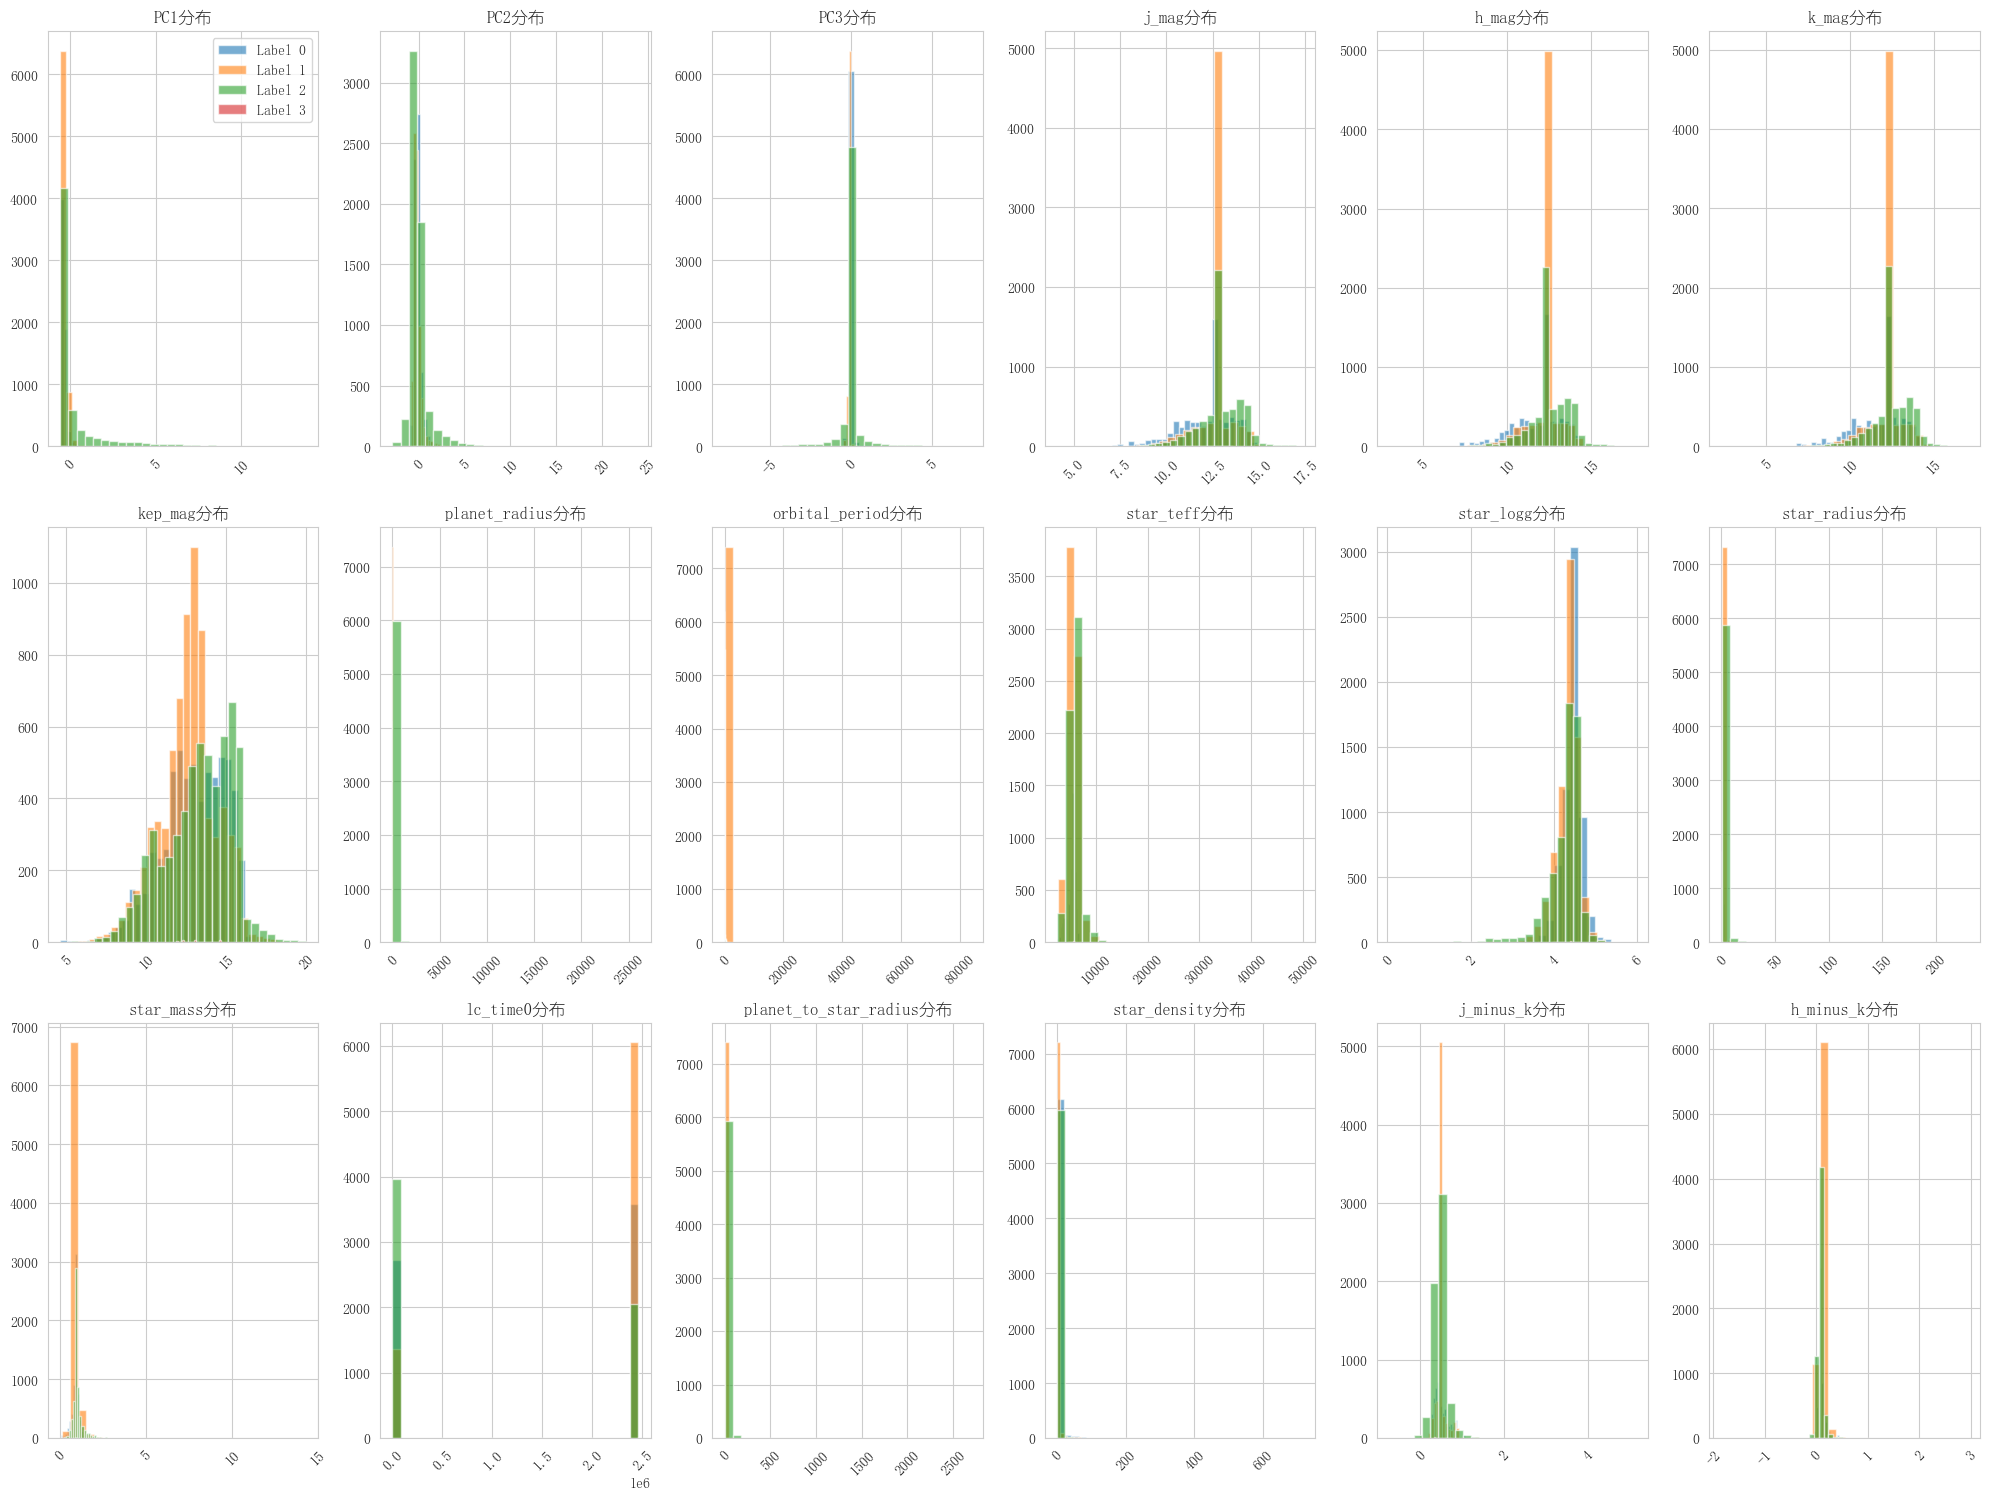

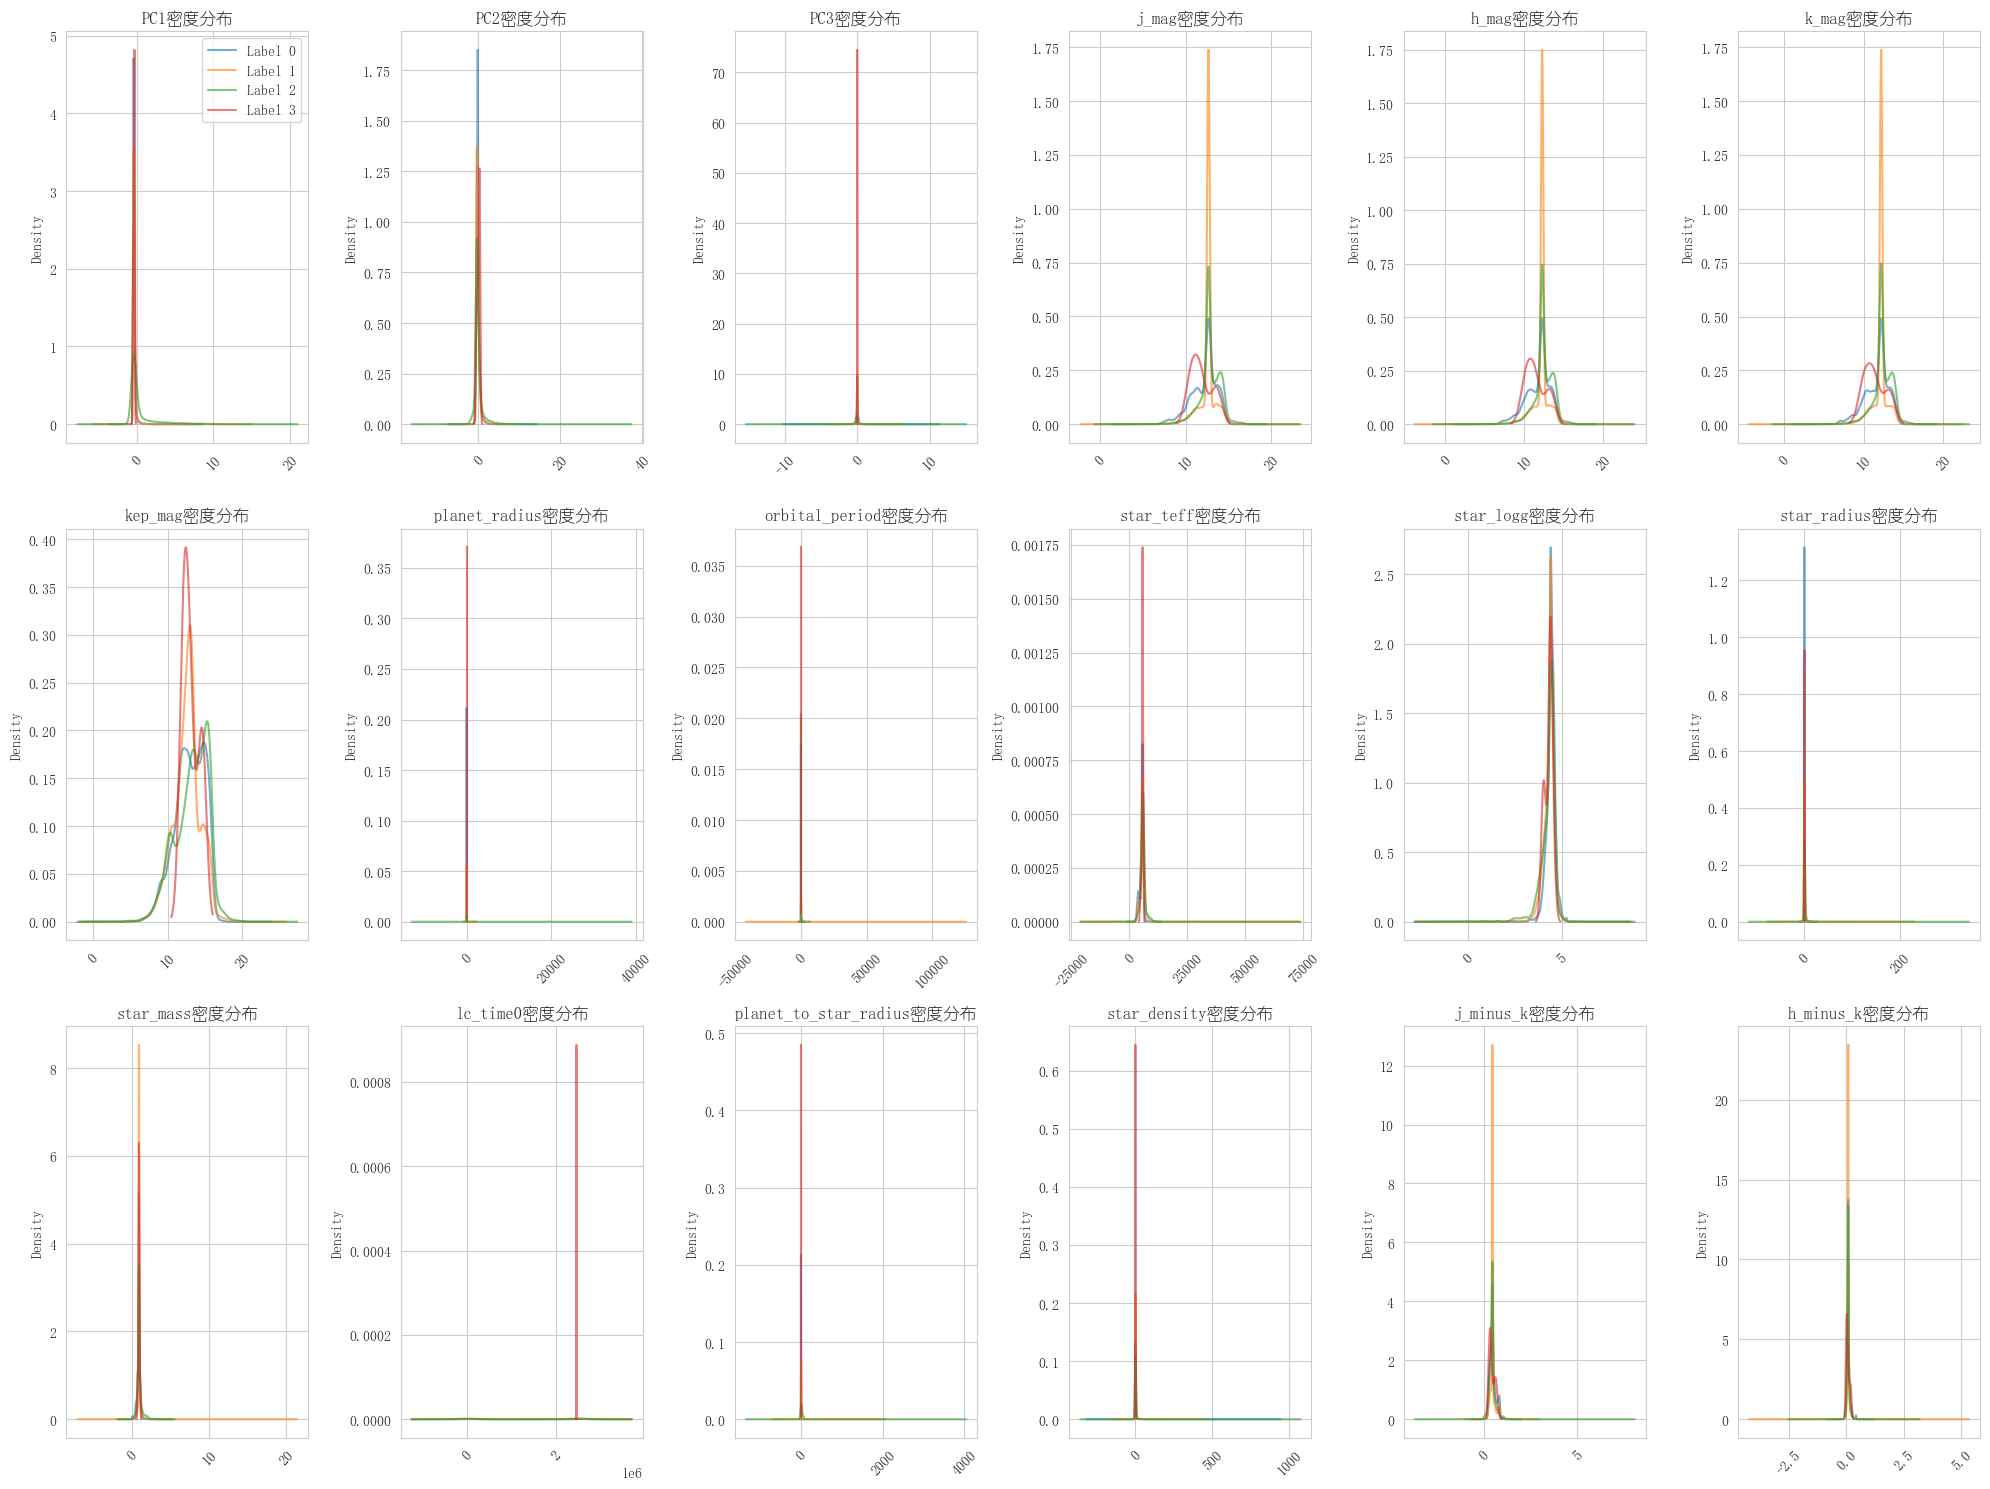

In [9]:
print("数值特征的描述性统计：")
print(ML_ready.describe())

# 选择数值型特征（排除坐标和标签）
numeric_features = ['PC1', 'PC2', 'PC3', 'j_mag', 'h_mag', 'k_mag', 'kep_mag', 
                   'planet_radius', 'orbital_period', 'star_teff', 'star_logg', 
                   'star_radius', 'star_mass', 'lc_time0','planet_to_star_radius','star_density',
                   'j_minus_k','h_minus_k','radius_times_period','radius_over_mass']

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_features[:18], 1):
    plt.subplot(3, 6, i)
    # 移除KDE，使用简单的直方图
    for label_value in sorted(ML_ready['label'].unique()):
        subset = ML_ready[ML_ready['label'] == label_value]
        plt.hist(subset[col], alpha=0.6, label=f'Label {label_value}', bins=30)
    plt.title(f'{col}分布')
    plt.xticks(rotation=45)
    if i == 1:  # 只在第一个子图显示图例
        plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_features[:18], 1):
    plt.subplot(3, 6, i)
    # 使用密度图而不是直方图+KDE
    for label_value in sorted(ML_ready['label'].unique()):
        subset = ML_ready[ML_ready['label'] == label_value]
        subset[col].plot.density(alpha=0.6, label=f'Label {label_value}')
    plt.title(f'{col}密度分布')
    plt.xticks(rotation=45)
    if i == 1:
        plt.legend()

plt.tight_layout()
plt.show()

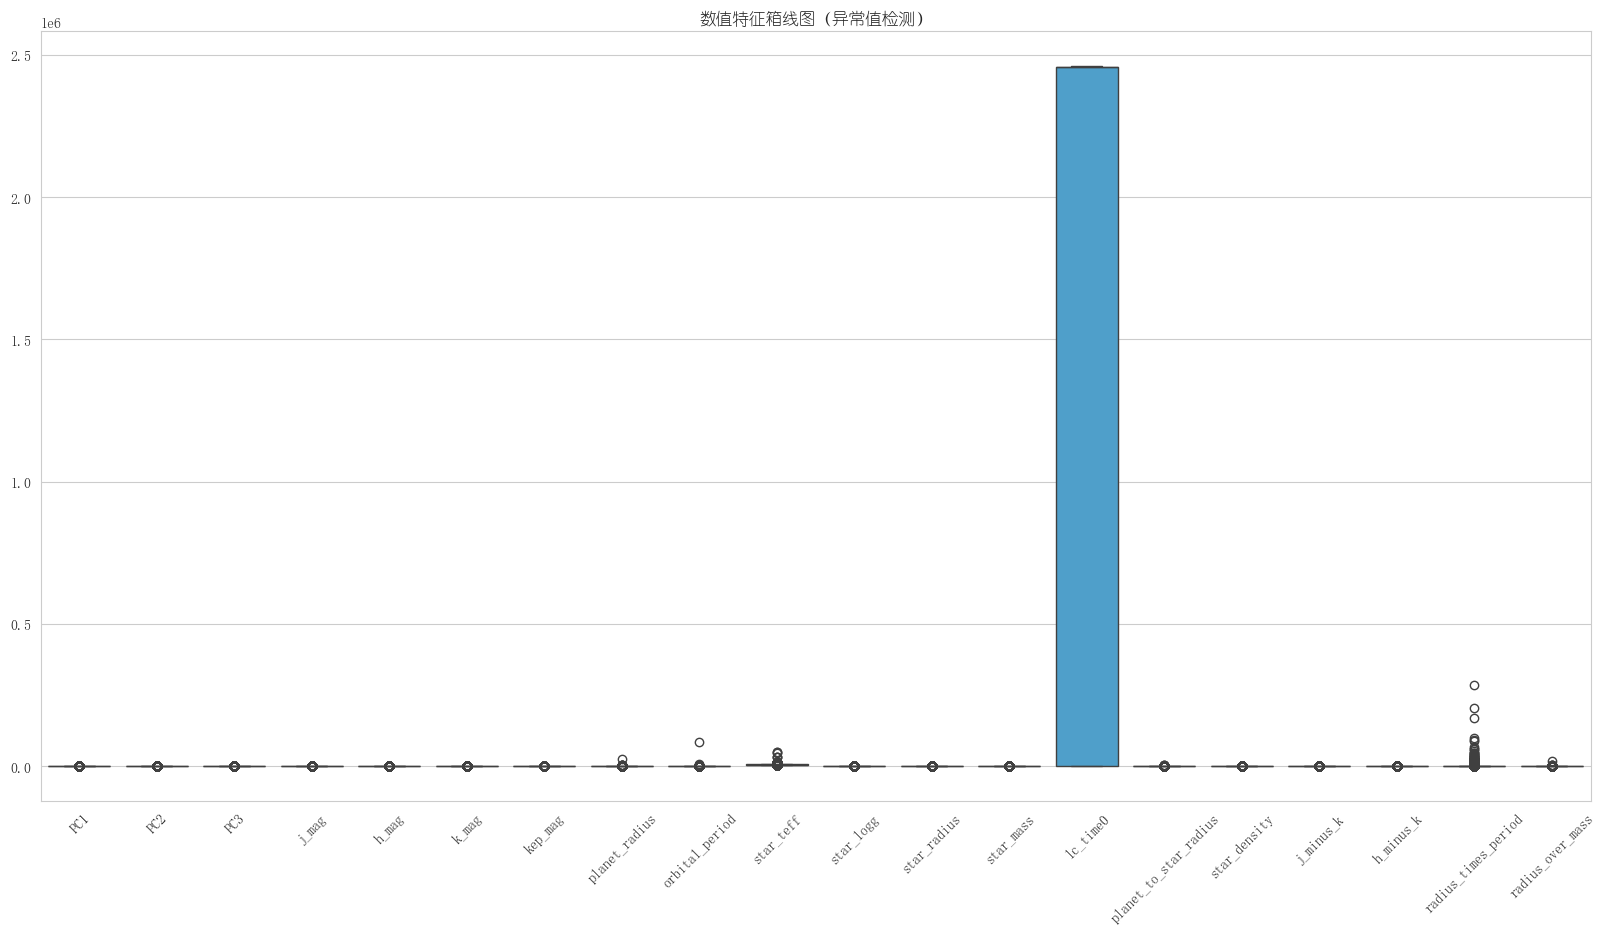

各特征的异常值数量：
PC1                      2127
PC2                      1657
PC3                      3417
j_mag                    3820
h_mag                    3909
k_mag                    3967
kep_mag                   119
planet_radius            1665
orbital_period           2257
star_teff                1925
star_logg                1156
star_radius              1316
star_mass                9173
lc_time0                    0
planet_to_star_radius    2041
star_density             1528
j_minus_k                4260
h_minus_k                4413
radius_times_period      2700
radius_over_mass         1676
dtype: int64


In [10]:
# 箱线图检测异常值
plt.figure(figsize=(20, 10))
sns.boxplot(data=ML_ready[numeric_features])
plt.title('数值特征箱线图（异常值检测）')
plt.xticks(rotation=45)
plt.show()

# 计算每个特征的异常值数量
Q1 = ML_ready[numeric_features].quantile(0.25)
Q3 = ML_ready[numeric_features].quantile(0.75)
IQR = Q3 - Q1

outliers = ((ML_ready[numeric_features] < (Q1 - 1.5 * IQR)) | 
           (ML_ready[numeric_features] > (Q3 + 1.5 * IQR))).sum()

print("各特征的异常值数量：")
print(outliers)

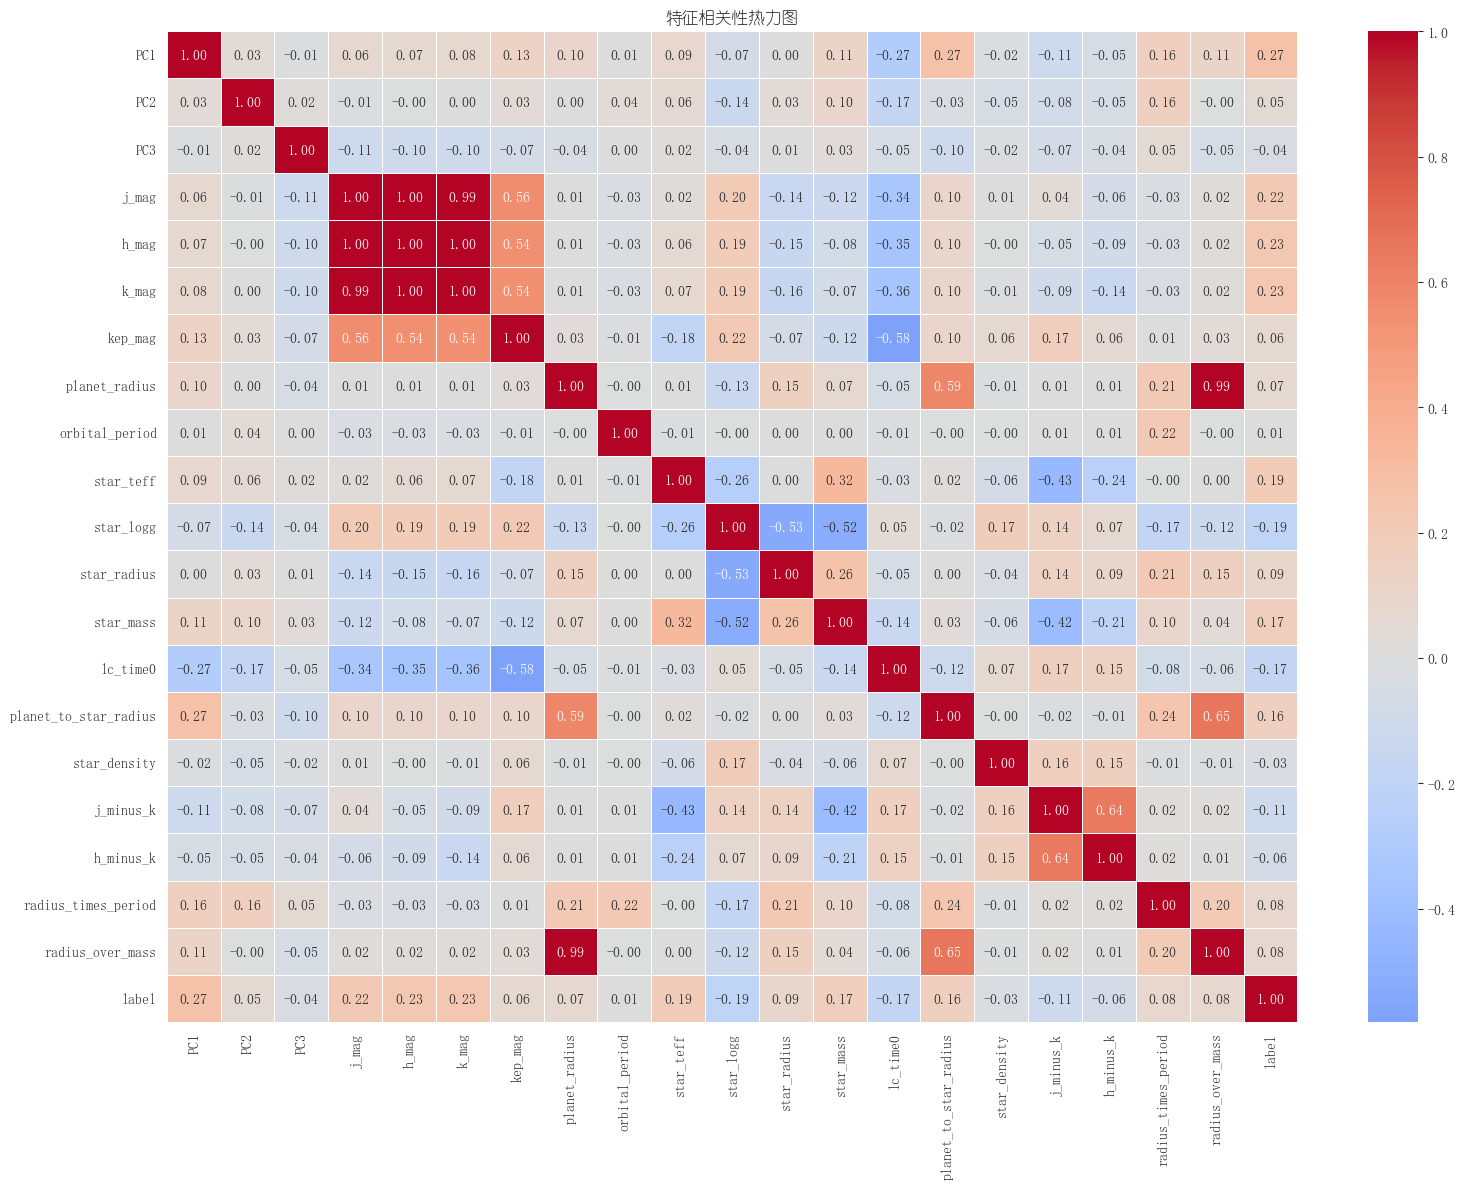

特征与目标变量的相关性排序：
PC1                      0.267412
k_mag                    0.229381
h_mag                    0.227265
j_mag                    0.216656
star_logg                0.194134
star_teff                0.193043
lc_time0                 0.173807
star_mass                0.170818
planet_to_star_radius    0.157241
j_minus_k                0.107241
star_radius              0.087587
radius_times_period      0.083322
radius_over_mass         0.077048
planet_radius            0.067205
kep_mag                  0.064882
h_minus_k                0.063803
PC2                      0.050495
PC3                      0.035245
star_density             0.026373
orbital_period           0.005211
Name: label, dtype: float64


In [11]:
# 计算特征相关性矩阵
correlation_matrix = ML_ready[numeric_features + ['label']].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5)
plt.title('特征相关性热力图')
plt.tight_layout()
plt.show()

# 查看与目标变量相关性最高的特征
label_correlations = correlation_matrix['label'].abs().sort_values(ascending=False)
print("特征与目标变量的相关性排序：")
print(label_correlations[1:])  # 排除label自身

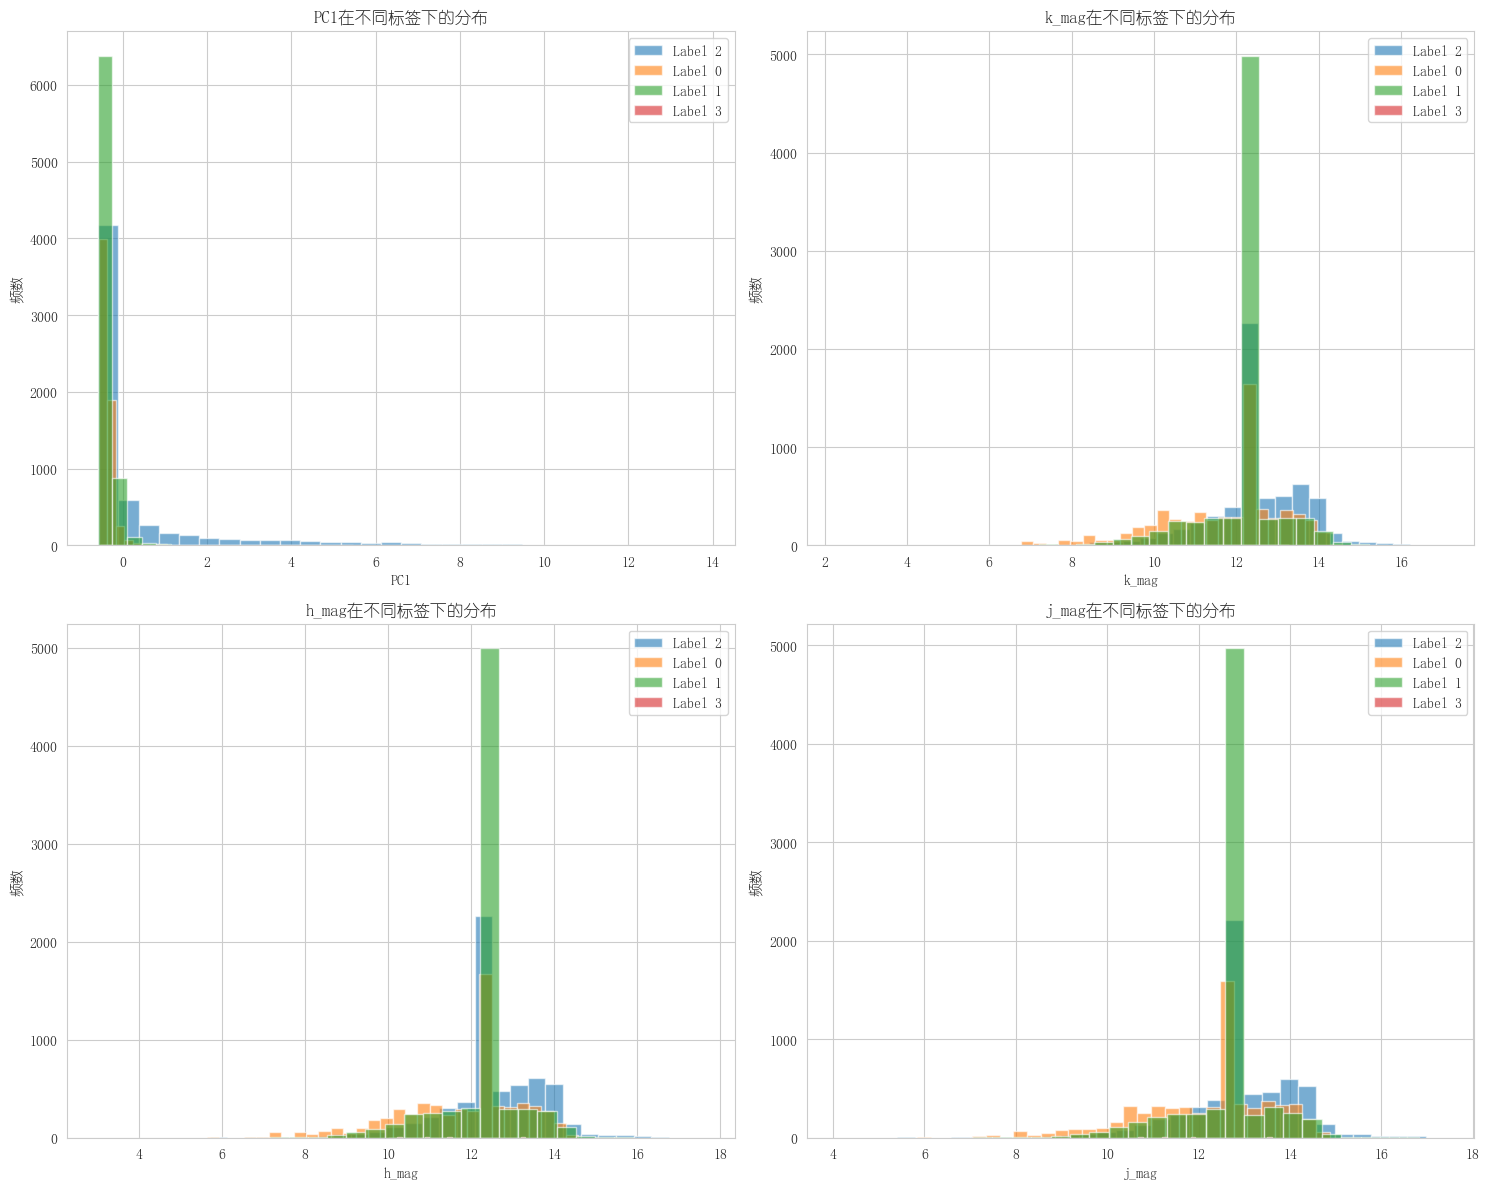

In [12]:
# 特征对分析（选择与label相关性最高的几个特征）
top_features = label_correlations[1:5].index.tolist()

plt.figure(figsize=(15, 12))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 2, i)
    for label_value in ML_ready['label'].unique():
        subset = ML_ready[ML_ready['label'] == label_value]
        plt.hist(subset[feature], alpha=0.6, label=f'Label {label_value}', bins=30)
    plt.xlabel(feature)
    plt.ylabel('频数')
    plt.legend()
    plt.title(f'{feature}在不同标签下的分布')

plt.tight_layout()
plt.show()

In [13]:
# 检查是否需要标准化
print("特征值范围检查：")
feature_ranges = ML_ready[numeric_features].agg(['min', 'max', 'std'])
print(feature_ranges)

# 检查数据平衡性
class_balance = ML_ready['label'].value_counts(normalize=True)
print(f"\n类别平衡性：")
print(class_balance)

if class_balance.min() < 0.1:  # 如果最小类别占比小于10%
    print("警告：数据可能存在类别不平衡问题")

特征值范围检查：
           PC1        PC2       PC3      j_mag      h_mag      k_mag  \
min  -0.591683  -2.864373 -7.777481   4.097000   3.014000   2.311000   
max  13.803377  24.012589  7.424680  17.372000  17.615000  17.038000   
std   1.024262   0.799844  0.503856   1.232746   1.228578   1.236581   

       kep_mag  planet_radius  orbital_period     star_teff  star_logg  \
min   4.627800       0.036257        0.152076   2520.000000   0.047000   
max  20.003000   26042.900000    83830.000000  50000.000000   5.960650   
std   1.964285     198.858223      606.676580   1165.439181   0.345673   

     star_radius  star_mass      lc_time0  planet_to_star_radius  \
min     0.109000   0.000000  1.205659e+02               0.054041   
max   229.908000  14.336000  2.460863e+06            2693.164426   
std     4.335476   0.261247  1.208171e+06              47.709361   

     star_density  j_minus_k  h_minus_k  radius_times_period  radius_over_mass  
min      0.000000  -0.744000  -1.834000            

In [16]:
# 准备特征和目标变量
X = ML_ready.drop('label', axis=1)
y = ML_ready['label']

print(f"特征维度: {X.shape}")
print(f"目标变量维度: {y.shape}")

# 检查是否需要进行特征缩放
# 只对数值特征进行标准化，并先处理无穷大或过大的值
X_numeric = X[numeric_features].replace([np.inf, -np.inf], np.nan)

# 如果存在NaN（包括原来的NaN和替换出来的inf），用中位数填充
nan_counts = X_numeric.isna().sum()
if nan_counts.any():
	print("发现NaN或无穷大值，按列用中位数填充：")
	print(nan_counts[nan_counts > 0])
	X_numeric = X_numeric.fillna(X_numeric.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

print(f"标准化后的数据范围: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")

特征维度: (19761, 22)
目标变量维度: (19761,)
发现NaN或无穷大值，按列用中位数填充：
radius_over_mass    1
dtype: int64
标准化后的数据范围: [-27.67, 138.13]


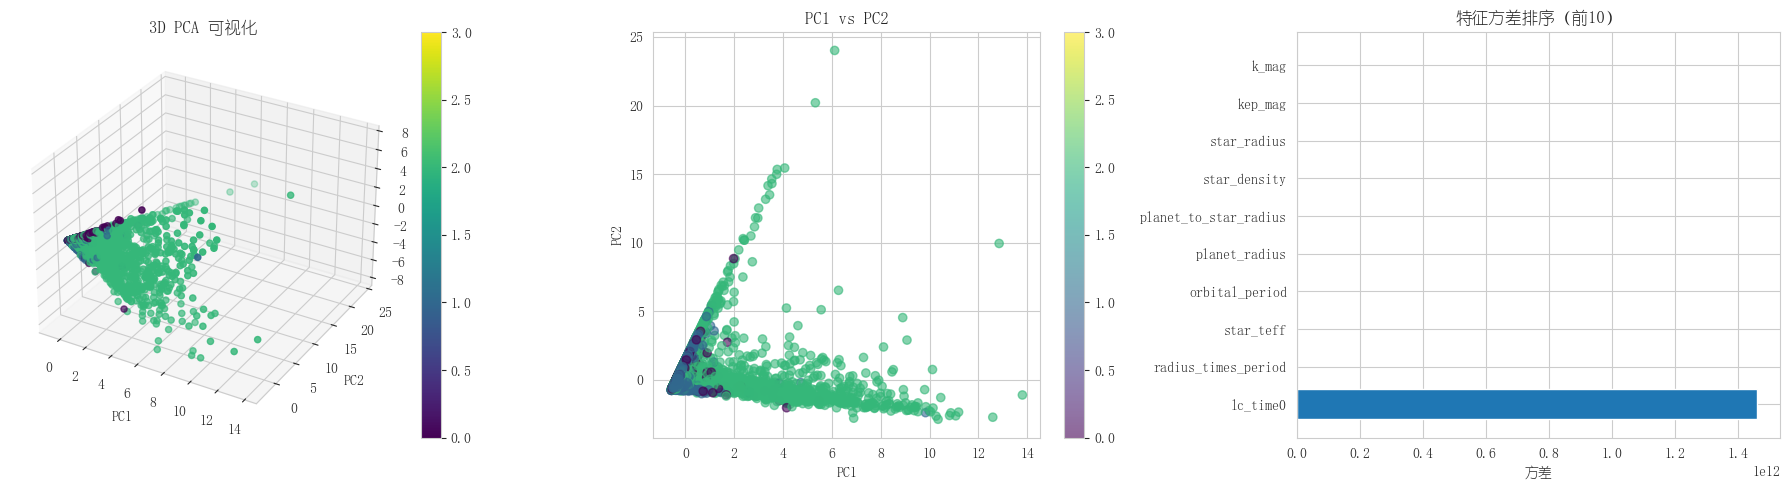

In [17]:
# 主成分分析可视化（如果PC1-3是主成分）
if {'PC1', 'PC2', 'PC3'}.issubset(ML_ready.columns):
    fig = plt.figure(figsize=(18, 5))
    
    # PC1 vs PC2
    ax1 = fig.add_subplot(131, projection='3d')
    scatter = ax1.scatter(ML_ready['PC1'], ML_ready['PC2'], ML_ready['PC3'], 
                         c=ML_ready['label'], cmap='viridis')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    plt.colorbar(scatter)
    ax1.set_title('3D PCA 可视化')
    
    # PC1 vs PC2 (2D)
    plt.subplot(132)
    scatter = plt.scatter(ML_ready['PC1'], ML_ready['PC2'], c=ML_ready['label'], 
                         cmap='viridis', alpha=0.6)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter)
    plt.title('PC1 vs PC2')
    
    # 特征重要性（基于方差）
    plt.subplot(133)
    variances = ML_ready[numeric_features].var().sort_values(ascending=False)
    plt.barh(range(len(variances[:10])), variances.values[:10])
    plt.yticks(range(len(variances[:10])), variances.index[:10])
    plt.xlabel('方差')
    plt.title('特征方差排序（前10）')
    
    plt.tight_layout()
    plt.show()

# 算法尝试

In [22]:
# 准备特征和目标变量
X = ML_ready.drop('label', axis=1)
y = ML_ready['label']

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 只对数值特征进行标准化，并先处理无穷大或过大的值
X_train_numeric = X_train[numeric_features].replace([np.inf, -np.inf], np.nan)
X_test_numeric = X_test[numeric_features].replace([np.inf, -np.inf], np.nan)

# 用中位数填充NaN
X_train_numeric = X_train_numeric.fillna(X_train_numeric.median())
X_test_numeric = X_test_numeric.fillna(X_train_numeric.median())  # 用训练集中位数填充测试集

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")
print(f"类别分布:\n{y.value_counts(normalize=True)}")

训练集大小: (15808, 22)
测试集大小: (3953, 22)
类别分布:
label
1    0.375133
0    0.319366
2    0.304387
3    0.001113
Name: proportion, dtype: float64


In [25]:
import math
sum(np.isinf(X_train_scaled))
sum(np.isinf(X_test_scaled))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
# 初始化分类器
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

# 存储结果
results = {}
cv_results = {}

print("开始训练各种分类器...")
print("=" * 50)

for name, clf in classifiers.items():
    print(f"训练 {name}...")
    
    # 选择是否使用标准化数据
    if name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test
    
    # 训练模型
    clf.fit(X_tr, y_train)
    
    # 预测
    y_pred = clf.predict(X_te)
    
    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)
    
    # 交叉验证
    cv_scores = cross_val_score(clf, X_tr, y_train, cv=5, scoring='accuracy')
    
    # 存储结果
    results[name] = {
        'model': clf,
        'accuracy': accuracy,
        'predictions': y_pred,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name}: 测试准确率 = {accuracy:.4f}, 交叉验证准确率 = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

开始训练各种分类器...
训练 Logistic Regression...
Logistic Regression: 测试准确率 = 0.6124, 交叉验证准确率 = 0.6149 (±0.0040)
训练 Random Forest...


ValueError: Input X contains infinity or a value too large for dtype('float32').


模型性能比较:
                 Model  Test Accuracy  CV Mean Accuracy    CV Std
1        Random Forest       0.773590          0.771192  0.005273
7              XGBoost       0.768277          0.776759  0.005170
2    Gradient Boosting       0.721983          0.741144  0.005602
5        Decision Tree       0.684796          0.682692  0.005659
3                  SVM       0.638249          0.651316  0.005325
4  K-Nearest Neighbors       0.632937          0.631895  0.008780
0  Logistic Regression       0.609158          0.612285  0.006128
6          Naive Bayes       0.265621          0.308706  0.037872


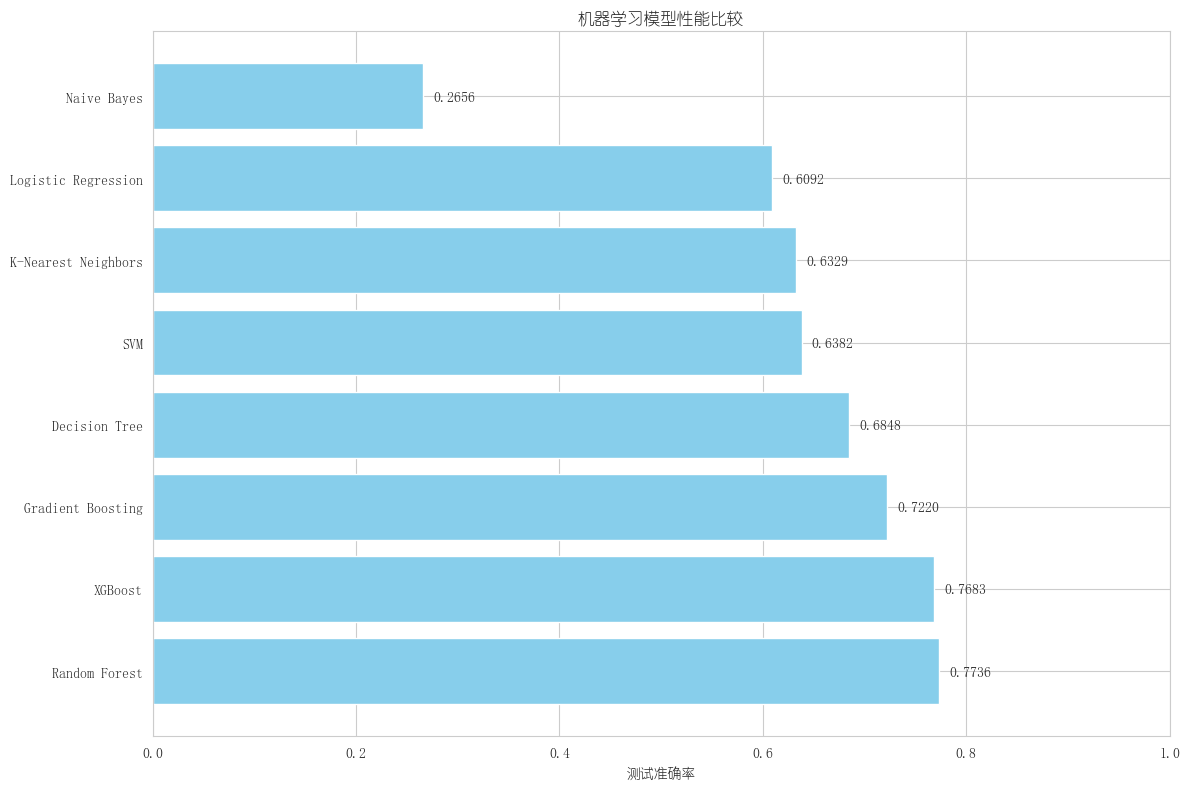

In [17]:
# 创建比较表格
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'CV Mean Accuracy': [results[name]['cv_mean'] for name in results.keys()],
    'CV Std': [results[name]['cv_std'] for name in results.keys()]
}).sort_values('Test Accuracy', ascending=False)

print("\n模型性能比较:")
print(comparison_df)

# 可视化比较
plt.figure(figsize=(12, 8))
models = comparison_df['Model']
y_pos = np.arange(len(models))
accuracy = comparison_df['Test Accuracy']

plt.barh(y_pos, accuracy, color='skyblue')
plt.yticks(y_pos, models)
plt.xlabel('测试准确率')
plt.title('机器学习模型性能比较')
plt.xlim(0, 1)

# 在条形上添加准确率数值
for i, v in enumerate(accuracy):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()


最佳模型: Random Forest
详细分类报告:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1263
           1       0.72      0.78      0.75      1483
           2       0.82      0.74      0.77      1203
           3       1.00      0.50      0.67         4

    accuracy                           0.77      3953
   macro avg       0.84      0.70      0.75      3953
weighted avg       0.78      0.77      0.77      3953



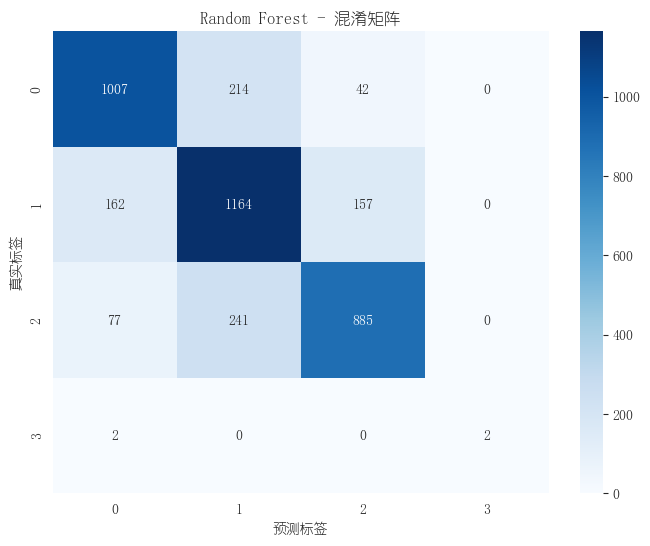

In [18]:
# 选择最佳模型
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"\n最佳模型: {best_model_name}")
print("=" * 50)

# 详细分类报告
print("详细分类报告:")
print(classification_report(y_test, best_predictions))

# 混淆矩阵
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'{best_model_name} - 混淆矩阵')
plt.ylabel('真实标签')
plt.xlabel('预测标签')
plt.show()

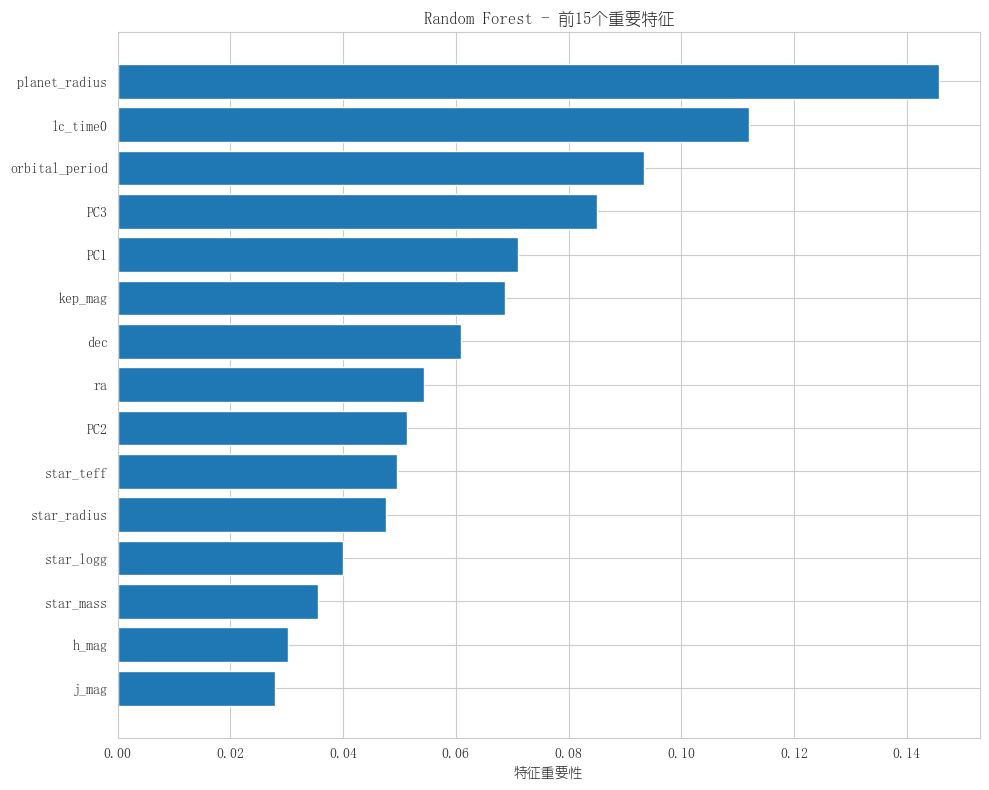

前10个最重要特征:
           feature  importance
9    planet_radius    0.145736
15        lc_time0    0.112087
10  orbital_period    0.093468
2              PC3    0.085115
0              PC1    0.071033
8          kep_mag    0.068693
4              dec    0.060929
3               ra    0.054327
1              PC2    0.051269
11       star_teff    0.049553


In [19]:
# 如果最佳模型是树模型，分析特征重要性
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['feature'][:15], 
             feature_importance['importance'][:15])
    plt.xlabel('特征重要性')
    plt.title(f'{best_model_name} - 前15个重要特征')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("前10个最重要特征:")
    print(feature_importance.head(10))

In [21]:
# 对随机森林进行超参数调优
if 'Random Forest' in classifiers:
    print("\n开始随机森林超参数调优...")
    sample_size = min(5000, len(X_train))
    X_train_sample = X_train.sample(sample_size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]

    print(f"使用 {sample_size} 个样本进行快速调优")
    print(f"采样后类别分布:\n{y_train_sample.value_counts(normalize=True)}")
    rf = RandomForestClassifier(random_state=42)
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_sample, y_train_sample)
    
    print(f"最佳参数: {grid_search.best_params_}")
    print(f"最佳交叉验证分数: {grid_search.best_score_:.4f}")
    
    # 使用最佳参数重新训练
    best_rf = grid_search.best_estimator_
    y_pred_rf_tuned = best_rf.predict(X_test)
    accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
    
    print(f"调优后的测试准确率: {accuracy_rf_tuned:.4f}")
    
    # 比较调优前后的性能
    original_accuracy = results['Random Forest']['accuracy']
    improvement = accuracy_rf_tuned - original_accuracy
    print(f"性能提升: {improvement:.4f}")


开始随机森林超参数调优...
使用 5000 个样本进行快速调优
采样后类别分布:
label
1    0.3710
0    0.3166
2    0.3110
3    0.0014
Name: proportion, dtype: float64
Fitting 5 folds for each of 81 candidates, totalling 405 fits
最佳参数: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
最佳交叉验证分数: 0.7574
调优后的测试准确率: 0.7361
性能提升: -0.0374


In [22]:
# 模型集成
# 使用投票集成
from sklearn.ensemble import VotingClassifier

# 选择前3个最佳模型
top_models = comparison_df.head(3)['Model'].tolist()
print(f"\n使用前3个模型进行集成: {top_models}")

estimators = []
for name in top_models:
    estimators.append((name, results[name]['model']))

# 创建投票分类器
voting_clf = VotingClassifier(estimators=estimators, voting='hard')
voting_clf.fit(X_train, y_train)

# 评估集成模型
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)

print(f"集成模型准确率: {accuracy_voting:.4f}")

# 与最佳单一模型比较
if accuracy_voting > comparison_df.iloc[0]['Test Accuracy']:
    print("集成模型性能优于最佳单一模型!")
else:
    print("最佳单一模型性能更好。")


使用前3个模型进行集成: ['Random Forest', 'XGBoost', 'Gradient Boosting']
集成模型准确率: 0.7670
最佳单一模型性能更好。


In [23]:
import joblib

# 保存最佳模型和标准化器
joblib.dump(best_model, 'best_classifier_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print(f"\n最佳模型已保存为 'best_classifier_model.pkl'")
print(f"标准化器已保存为 'scaler.pkl'")

# 保存所有结果
results_summary = {
    'best_model': best_model_name,
    'best_accuracy': comparison_df.iloc[0]['Test Accuracy'],
    'all_results': comparison_df.to_dict()
}

import json
with open('model_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("所有结果已保存为 'model_results.json'")


最佳模型已保存为 'best_classifier_model.pkl'
标准化器已保存为 'scaler.pkl'
所有结果已保存为 'model_results.json'
